In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from model.MinAggGNN import MinAggGNN
import matplotlib.pyplot as plt

device = torch.device('cuda')
L = 2
m = 2
epochs = 20000
eta = 0.001

model = MinAggGNN(1, 8, L, 1, edge_dim = 1)
state_dict = torch.load('model_progress/bellman_ford/model_final.pt')
model.load_state_dict(state_dict)
model.eval()
model.to(device)

MinAggGNN(1, 1, num_layers=2)

In [2]:
from MINAR.ComputationGraph import ComputationGraph, Circuit
from model.CustomLosses import MultiplicativeLoss
import torch_geometric as pyg
import networkx as nx

G = ComputationGraph(model)
G.add_inputs({'edge_attr' : [1, model.convs[0].agg_mlp.lins[0].weight[:,-1]],
              'input_self' : [3, model.convs[0].up_mlp.lins[0].weight[:,-1]]})
G.add_residual_connections({'edge_attr' : [5, model.convs[1].agg_mlp.lins[0].weight[:,-1].reshape(1,-1).cpu().detach()]})
G.add_residual_connections({4 : [7, model.convs[1].up_mlp.lins[0].weight[:,-8:].T.cpu().detach()]})
G.number_of_edges()

18240

In [3]:
# criterion = MultiplicativeLoss()
criterion = torch.nn.MSELoss()
test_data = torch.load('data/test_data.pt', map_location=device)
corrupted_data = torch.load('data/test_data.pt', map_location=device)
for data_corr in corrupted_data:
    data_corr.x = torch.zeros_like(data_corr.x, device=device)
    data_corr.x[0] = 1000.
    data_corr.edge_attr = torch.zeros_like(data_corr.edge_attr, device=device)

G.calculate_scores(test_data, corrupted_data, criterion, which = 'weight_grad')
G.calculate_scores(test_data, corrupted_data, criterion, which = 'EAP')
G.calculate_scores(test_data, corrupted_data, criterion, which = 'EAP-IG', steps=20)

c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


In [4]:
# which = 'weight'
# which = 'weight_grad'
# which = 'EAP'
which = 'EAP-IG'
K = 6
C = Circuit(model, G, K=K, key=which)
print(C.number_of_edges())

17


In [5]:
test_loader = pyg.loader.DataLoader(test_data, batch_size = len(test_data))
criterion = MultiplicativeLoss()
num_reachable_test_nodes = sum([data.reachable.sum() for data in test_loader])
for data in test_loader:
    out = C.forward(data)
    mul_circuit_loss = float(criterion(out[data.reachable].flatten(), data.y[data.reachable]).detach()) / num_reachable_test_nodes
    print(f'Circuit Test Loss: {mul_circuit_loss:.4f}')

Circuit Test Loss: 0.0644


c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


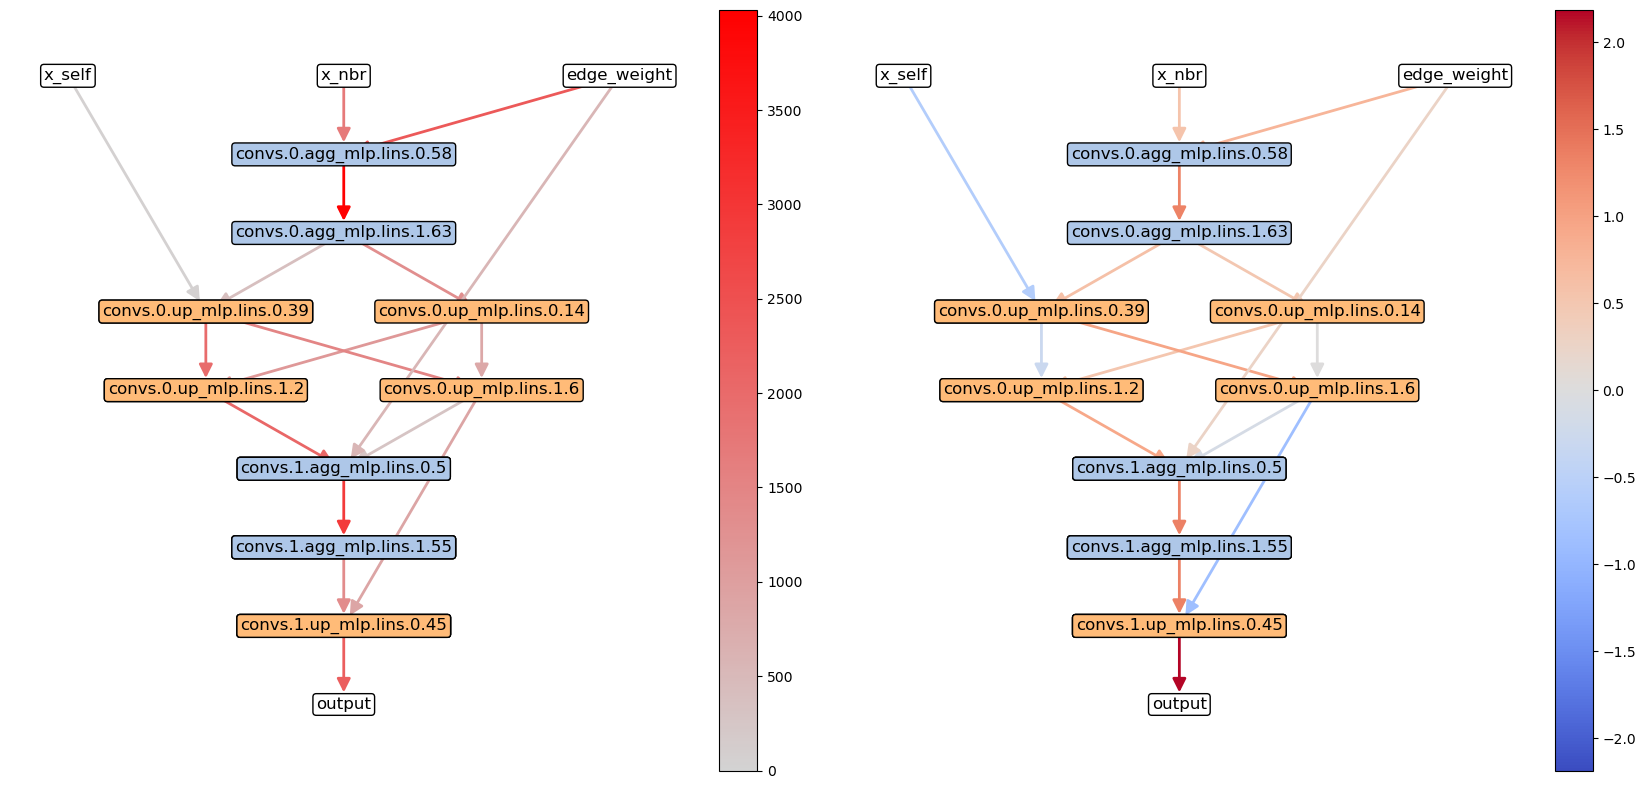

In [102]:
from matplotlib import colors, cm

nx.relabel_nodes(C, {C.layers[-1][0] : 'output',
                     'input.0' : 'x_nbr',
                     'input_self' : 'x_self',
                     'edge_attr' : 'edge_weight'}, copy=False)
C.layers[0] = ['x_nbr', 'x_self', 'edge_weight']
C.layers[-1] = ['output']

fig, ax = plt.subplots(1, 2, figsize=(17, 8))
c_pos = nx.multipartite_layout(C, subset_key='layer', align='horizontal')
c_pos = {node: (x,-y) for (node, (x,y)) in c_pos.items()}
tmp = c_pos['x_nbr']
c_pos['x_nbr'] = c_pos['edge_weight']
c_pos['edge_weight'] = c_pos['x_self']
c_pos['x_self'] = tmp

cvals  = [0, 2]
cs = ["lightgray","red"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), cs))
cmap = colors.LinearSegmentedColormap.from_list("", tuples)

layer_colors = ['white', cm.tab20(1), cm.tab20(1), cm.tab20(3), cm.tab20(3), cm.tab20(1), cm.tab20(1), cm.tab20(3), 'white']

circuit_edges, circuit_edge_scores = zip(*nx.get_edge_attributes(C,which).items())
max_score = max(circuit_edge_scores)
for color, layer in zip(layer_colors, C.layers):
        nx.draw_networkx_labels(C, pos = c_pos, ax=ax[0],
                                labels={node : node for node in layer},
                                bbox=dict(facecolor=color, edgecolor="black", boxstyle="round,pad=0.2")
        )
score_edges = nx.draw_networkx_edges(C, pos = c_pos, ax=ax[0],
        edge_color=circuit_edge_scores,
        width=2,
        arrowsize=20,
        edge_vmin=0,
        edge_vmax=max_score,
        edge_cmap=cmap
)
fig.colorbar(cm.ScalarMappable(colors.Normalize(vmin=0, vmax=max_score),
             cmap=cmap),
             ax=ax[0])
ax[0].set_axis_off()

_, circuit_edge_weights = zip(*nx.get_edge_attributes(C,'weight').items())
abs_vmax = abs(max(circuit_edge_weights, key=abs))
for color, layer in zip(layer_colors, C.layers):
        nx.draw_networkx_labels(C, pos = c_pos, ax=ax[1],
                                labels={node : node for node in layer},
                                bbox=dict(facecolor=color, edgecolor="black", boxstyle="round,pad=0.2")
        )
score_edges = nx.draw_networkx_edges(C, pos = c_pos, ax=ax[1],
        edge_color=circuit_edge_weights,
        width=2,
        arrowsize=20,
        edge_vmin=-abs_vmax,
        edge_vmax=abs_vmax,
        edge_cmap=plt.cm.coolwarm
)
fig.colorbar(cm.ScalarMappable(colors.Normalize(vmin=-abs_vmax, vmax=abs_vmax),
             cmap=plt.cm.coolwarm),
             ax=ax[1])
ax[1].set_axis_off()
plt.tight_layout()
plt.savefig('images/bellman_ford_circuit.pdf', bbox_inches='tight')

In [7]:
from tqdm import tqdm
mse_criterion = torch.nn.MSELoss()
score_methods = ['weight', 'weight_grad', 'EAP', 'EAP-IG']
circuit_mse_losses = {score : [] for score in score_methods}
circuit_test_losses = {score : [] for score in score_methods}
actual_node_count = {score : [] for score in score_methods}
actual_edge_count = {score : [] for score in score_methods}
pbar = tqdm(range(20))
for K in pbar:
    for score in score_methods:
        for data in test_loader:
            C_tmp = Circuit(model, G, K=K, key=score)
            out = C_tmp.forward(data).flatten()
            mse_circuit_loss = float(mse_criterion(out[data.reachable], data.y[data.reachable]).detach()) / len(test_data)
            mul_circuit_loss = float(criterion(out[data.reachable], data.y[data.reachable]).detach()) / len(test_data)
            circuit_mse_losses[score].append(mse_circuit_loss)
            circuit_test_losses[score].append(mul_circuit_loss)
            actual_node_count[score].append(C_tmp.number_of_nodes())
            actual_edge_count[score].append(C_tmp.number_of_edges())

  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████| 20/20 [03:23<00:00, 10.15s/it]


Text(0.5, 0, 'Edges')

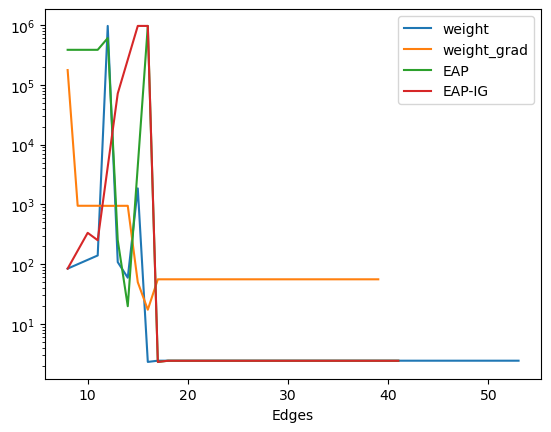

In [8]:
for score in score_methods:
    plt.plot(actual_edge_count[score], circuit_test_losses[score], label=score)

plt.yscale('log')
plt.legend()
plt.xlabel('Edges')

In [9]:
checkpoints = torch.load('model_progress/bellman_ford/model_checkpoints.pt')
circuit_losses = []
for checkpoint in checkpoints:
    model.load_state_dict(checkpoint)
    C.model_state_dict = checkpoint
    for data in test_loader:
        out = C.forward(data).flatten()
        circuit_losses.append(float(criterion(out[data.reachable], data.y[data.reachable]).detach() / num_reachable_test_nodes))

In [10]:
mse_losses = torch.load('model_progress/bellman_ford/mse_losses.pt')
l1_regs = torch.load('model_progress/bellman_ford/l1_regs.pt')
test_losses = torch.load('model_progress/bellman_ford/test_losses.pt')

In [11]:
torch.save(circuit_losses, 'model_progress/bellman_ford/circuit_losses.pt')

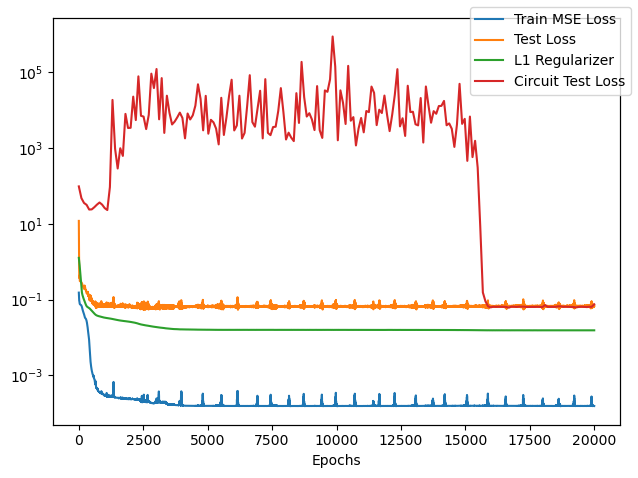

In [12]:
fig, ax = plt.subplots()
ax.plot(mse_losses.detach(), label='Train MSE Loss')
ax.plot(test_losses.detach(), label='Test Loss')
ax.plot((eta * l1_regs).detach(), label='L1 Regularizer')
ax2 = ax.twiny()
ax2.plot(circuit_losses, color='tab:red', label='Circuit Test Loss')
# ax2.plot(circuit_mse_losses['EAP-IG'], color='tab:red', label='Circuit Test Loss')
ax2.set_xticks([])
ax.set_yscale('log')
ax.set_xlabel('Epochs')
fig.legend()
plt.tight_layout()